In [6]:
# Third party
import importlib
import torch
import matplotlib.pyplot as plt

# User
import base.abstract
import base.mlp
import base.train
import base.encode
import base.pre_process
import model
import attention

importlib.reload(base.abstract)
importlib.reload(base.mlp)
importlib.reload(base.train)
importlib.reload(base.encode)
importlib.reload(base.pre_process)
importlib.reload(base.norm)
importlib.reload(model)
importlib.reload(attention)

from base.train import sgd
from base.encode import get_encoder_decoder
from base.mlp import LinearLayer, MLP
from base.train import sgd
from base.pre_process import get_dataset
from model import Attention
from attention import BatchedAttentionHead
from encode import positional_encode

In [2]:
encoder, decoder = get_encoder_decoder(training_data="../data/shakespear.txt", type='character')
# let's now encode the entire text dataset and store it into a torch.Tensor
with open("../data/shakespear.txt", 'r', encoding='utf-8') as f:
    text = f.read()
text_encoded = torch.tensor(encoder(text), dtype=torch.long)
unique_chars = sorted(list(set(text)))

In [3]:
token_length = 3
dataset =  get_dataset(text_encoded, 3, context_window="expanding")
train_data, train_targets = dataset["train"]
validation_data, validation_targets = dataset["validation"]
len(train_data), len(validation_data)

(948085, 167309)

In [7]:
hp = {
    "init_learning_rate": .1,
    "converging_learning_rate": .01,
    "epochs": 100000,
    "dim_of_embedding": 2,
    "dim_of_attention_embedding": 2,
    "num_layer_1_nodes": 10,
    "mini_batch_size": 3,
    "token_length": 3,
}

params = {
    "num_of_unique_chars": len(unique_chars),
    "positional_encoding_func": positional_encode
}

l1 = LinearLayer(
    num_of_inputs=hp['dim_of_attention_embedding'], #3x8x3 3x10 = 3x8x10
    num_of_neurons=10,
    append_pre_activation_layer=True,
    activation_func=torch.tanh,
)
l2 = LinearLayer(
    num_of_inputs=10,
    num_of_neurons=len(unique_chars),
)

mlp_model = MLP(layers=[l1,l2])
attention_model = Attention(hp, mlp_model, **params)


In [8]:
attention_model.require_grad()
loss_list = []
sgd(hp
    , attention_model
    , training_inputs=train_data
    , training_targets=train_targets
    , loss_list=loss_list
)


epoch: 0 / 100000, loss: 5.8227
epoch: 10000 / 100000, loss: 2.5403
epoch: 20000 / 100000, loss: 2.6544
epoch: 30000 / 100000, loss: 2.8888
epoch: 40000 / 100000, loss: nan
epoch: 50000 / 100000, loss: nan
epoch: 60000 / 100000, loss: nan
epoch: 70000 / 100000, loss: nan
epoch: 80000 / 100000, loss: nan
epoch: 90000 / 100000, loss: nan


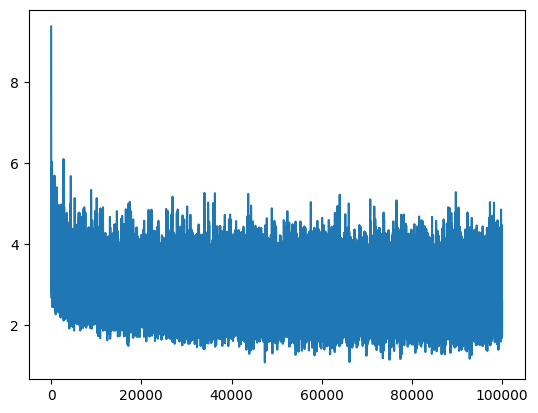

In [11]:
plt.plot(loss_list)


In [9]:
# Compute negative log likelihood of the train/validation

print(f"train loss: {attention_model.dataset_loss(train_data, train_targets)}")
print(f"validation loss: {attention_model.dataset_loss(validation_data, validation_targets)}" )

train loss: 2.687907058151861
validation loss: 2.6861607010568904


In [10]:
decoder(attention_model.generate(200))

"\n\nOT tetotottor?\nU\nN\n\nTR\nU\n ibh t  g hh u,o atho isoekaoiish eoueee'eoeas  pu; snanh ,  o.aw cr soa   s oatifm r f nivoat !dht dheo a ih enl. .  ,T,\nidotatlodtrnfdan kau i  \nsst s    oo l  poet; i?d d"